In [1]:
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program will plot the opposite-sign muon pair mass for all possible combinations of muons for each event.

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        muon_axis = hist.Bin("mass", "Muon Mass [GeV]", 50, 5, 100)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df["dataset"]
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content,
            eta=df['Muon_eta'].content,
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            charge=df['Muon_charge'].content
            )
        
        output['cutflow']['all muons'] += muons.mass.counts.sum()
        
        # Get all combinations of muon pairs in every event. distincts() generates tuples of all possible combinations within a single list. 
        dimuons = muons.distincts()
        output['cutflow']['all pairs'] += dimuons.mass.counts.sum()
        
        # Check that pairs have opposite charge. i0, i1, ... retrieve tuple values (in this case, i0 is the first muon, i1 the second)
        opposites = (dimuons.i0.charge != dimuons.i1.charge)
        
        # Mask the dimuon pairs with the opposites to get only oppositely-charged muon pairs.
        good_dimuons = dimuons[opposites]
        output['cutflow']['final pairs'] += good_dimuons.mass.counts.sum()
        
        output['mass'].fill(dataset=dataset, mass=good_dimuons['p4'].mass.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'SingleMu': ["data/Run2012B_SingleMu.root"]}
output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=Processor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4},
                                 chunksize = 250000)

/home/hep/madamec/.conda/envs/dask/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/hep/madamec/.conda/envs/dask/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/hep/madamec/.conda/envs/dask/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/hep/madamec/.conda/envs/dask/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))


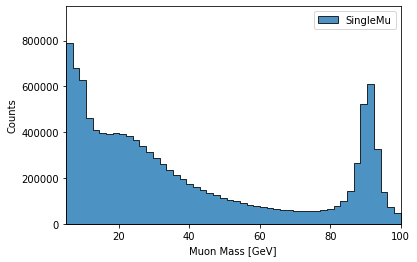

In [4]:
hist.plot1d(output['mass'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)

all muons 74439173
all pairs 31383312
final pairs 16051292
